# EX09 폐렴 정복하기

## 루브릭 평가 기준
#### 1. 의료영상을 처리하는 CNN 기반 딥러닝 모델이 잘 구현되었다.
#### 2. 데이터 준비, 모델구성 등의 과정의 다양한 실험이 체계적으로 수행되었다.
#### 3. 실습코드를 잘 개선하여 폐렴 검출 정확도가 추가로 향상되었다.

## 노드 실습 진행

In [1]:
import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel','E09')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 25

print(ROOT_PATH)

/aiffel/aiffel/E09


In [3]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


### 데이터 로드, 전처리

In [4]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [5]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/E09/chest_xray/data/train/NORMAL/NORMAL2-IM-1317-0001.jpeg
Pneumonia image path
/aiffel/aiffel/E09/chest_xray/data/train/PNEUMONIA/person299_bacteria_1418.jpeg


In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1072
Pneumonia images count in training set: 3113


In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [8]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [9]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [10]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [12]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [13]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [14]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

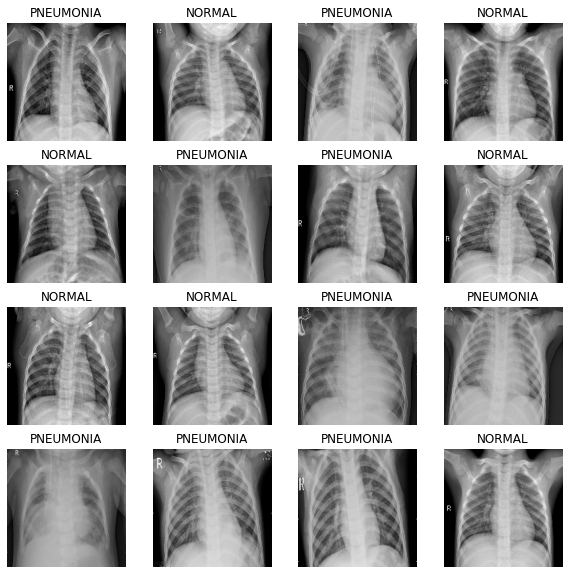

In [15]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

### __데이터 전처리 종료
>**리사이즈 외에 진행된 전처리 내용들이 잘 이해가 안간다. 뭘 한건지도 모르겠는데 왜 필요한지도 모르겠다. 노드의 컨텐츠 제작자마다 코드의 형태도 너무 달라서 보는데 너무 오래걸린다.**

### 모델 빌드

In [16]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [17]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [18]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

### 가중치 조절?

In [19]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.95
Weight for PNEUMONIA: 0.67


>**이내용도 뭔지 모르겠다. 데이터의 갯수가 적은만큼 가중치의 비중을 늘려서 학습정도를 맞추겠다는 의미인걸까?**

### 학습 및 테스트

In [20]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [21]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/25
261/261 [==============================] - 88s 206ms/step - loss: 0.3710 - accuracy: 0.8154 - precision: 0.9577 - recall: 0.7865 - val_loss: 0.6912 - val_accuracy: 0.7375 - val_precision: 0.7375 - val_recall: 1.0000
Epoch 2/25
261/261 [==============================] - 53s 205ms/step - loss: 0.2386 - accuracy: 0.9042 - precision: 0.9728 - recall: 0.8964 - val_loss: 1.2392 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/25
261/261 [==============================] - 54s 207ms/step - loss: 0.2009 - accuracy: 0.9260 - precision: 0.9788 - recall: 0.9205 - val_loss: 0.3684 - val_accuracy: 0.8288 - val_precision: 0.8116 - val_recall: 1.0000
Epoch 4/25
261/261 [==============================] - 55s 209ms/step - loss: 0.1727 - accuracy: 0.9320 - precision: 0.9812 - recall: 0.9263 - val_loss: 0.0862 - val_accuracy: 0.9692 - val_precision: 0.9919 - val_recall: 0.9660
Epoch 5/25
261/261 [==============================] - 56s 216ms/step - loss: 0.1582 - accura

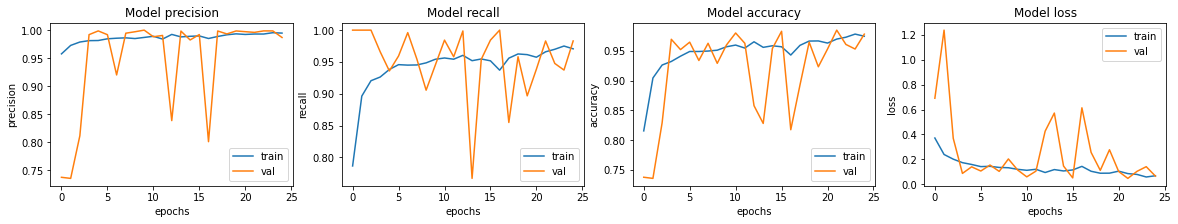

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [23]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 123ms/step - loss: 1.2051 - accuracy: 0.7644 - precision: 0.7288 - recall: 0.9923
Loss: 1.2050909996032715,
Accuracy: 0.7644230723381042,
Precision: 0.7288135886192322,
Recall: 0.9923076629638672


>**그래도 보통 train과 validation의 그래프의 형태가 어느정도 비슷했는데 이건 너무 이상하다. 이 그래프를 보고 진동이 심하다고 판단할 수 있는건가?**

### 모델 개선

In [37]:
BATCH_SIZE2 = 30
EPOCHS2 = 40

early_stop = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=10),
             tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                             monitor='val_loss',
                                             save_best_only=True,
                                               mode='auto')]

In [38]:
with tf.device('/GPU:0'):
    model2 = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model2.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [39]:
with tf.device('/GPU:0'):
    history2 = model2.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE2,
        epochs=EPOCHS2,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE2,
        class_weight=class_weight,
        callbacks=early_stop
    )

Epoch 1/40
139/139 [==============================] - 44s 241ms/step - loss: 0.4988 - accuracy: 0.7612 - precision: 0.9280 - recall: 0.7375 - val_loss: 0.5772 - val_accuracy: 0.7426 - val_precision: 0.7426 - val_recall: 1.0000
Epoch 2/40
139/139 [==============================] - 33s 236ms/step - loss: 0.2895 - accuracy: 0.8822 - precision: 0.9689 - recall: 0.8690 - val_loss: 0.7015 - val_accuracy: 0.7390 - val_precision: 0.7390 - val_recall: 1.0000
Epoch 3/40
139/139 [==============================] - 33s 235ms/step - loss: 0.2550 - accuracy: 0.8997 - precision: 0.9699 - recall: 0.8934 - val_loss: 1.1040 - val_accuracy: 0.7224 - val_precision: 0.7224 - val_recall: 1.0000
Epoch 4/40
139/139 [==============================] - 33s 238ms/step - loss: 0.2155 - accuracy: 0.9204 - precision: 0.9708 - recall: 0.9188 - val_loss: 1.7430 - val_accuracy: 0.7096 - val_precision: 0.7096 - val_recall: 1.0000
Epoch 5/40
139/139 [==============================] - 34s 243ms/step - loss: 0.2220 - accura

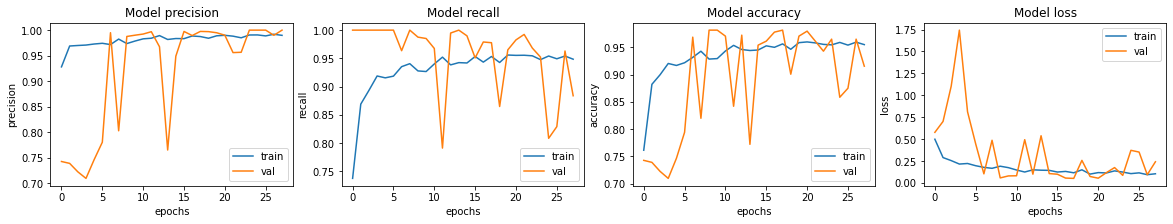

In [40]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history2.history[met])
    ax[i].plot(history2.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [41]:
loss, accuracy, precision, recall = model2.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 121ms/step - loss: 0.4007 - accuracy: 0.8766 - precision: 0.8771 - recall: 0.9333
Loss: 0.40067481994628906,
Accuracy: 0.8766025900840759,
Precision: 0.8771084547042847,
Recall: 0.9333333373069763


>**너무 단박에 목표결과에 도달하는 정도로 좋아져서 당황스럽다. 최초 batch size를 줄이고 epoch만 늘렸는데 오히려 성능이 떨어지는 것 같아 batch를 확 늘렸고, 학습이 생각보다 시간이 꽤 걸리기에 epoch을 확 늘리고 아예 early stop을 사용해보았다. 단박에 87%의 성능이 나왔다...**<br><br>
>**augmentation도 사용해보고 싶었는데 자꾸 data의 차원이 늘어나면서(shape이 (None, None, 180, 180, 3)이 되) 에러가 난다. 에러 내용을 기록했어야 되는데 깜빡했다. 원인도 모르겠고 수정할 자신이 없어서 코드 전체를 날려버렸다.**

# 회고

### 소 뒷걸음질치다 쥐 잡아...

제시된 방법론이 4-5가지로 꽤 많았는데 단박에 목표에 도달해서 놀랍고도 기뻣다. 다른 방법들도 모두 적용해보고 싶지만 괜히 도달한 내용이 날아갈까 겁이 나서(이미 여러차례 겪음) 건들지 않기로 했다. 오늘의 새로 배운 내용은 epochs, iteration, batch size의 관계에 대해서이다. 개념은 막연하게 이해했는데 어떤 데이터를 어떤 방법으로 학습하냐에 따라 어떤 방식으로 조절해야 하는지는 여전히 전혀 모르겠다. 아마 축적된 경험을 토대로 알게 되는건가 싶기도 하다. 그리고 보통 성공적인 모델에 대한 논문에 어느정도 범위에서 사용했는지 기록되어 있는 듯 하다. 아니면 좋은 결과가 나올 때까지 막 갓다대 보기로 하자. 노가다는 내 전공이니깐.

### 시간은 너무 빠르고 나는 거북이

아직 배운게 아무것도 없는 것 같은데 벌써 2월 중순을 향해 달려가고 있다. 많이 심사숙고했지만 결국 처음 생각한 CV가 아닌 NLP로 학습방향을 바꾸면서 갑자기 CV가 재미없다. 역시 일체유심조는 명언이 맞는 것 같다. ㅋㅋㅋ NLP는 할 생각이 없을 때도 재미없고 이해하기 어려웠는데 부디 나의 마음을 따라 갑자기 재밌고 쏙쏙 이해되었으면 좋겠다고 빌어본다. 심적으로 초조해서 그런지 나의 발전속도와 커리큘럼의 진도의 간극이 점점 벌어지는 기분이다ㅋㅋㅋㅋㅋㅋㅋ. 어떻게든 살아는 남겠지 라는 낙관으로 버티겠지만 아이펠 종료 이후가 더욱 막막해질 수도 있겠다. 컨텐츠 제작해주시는 분들의 코드 스타일(?)이 다들 달라서 좀 익숙해졌다 싶었던 나의 자신감을 다시 추락시킨다. 사실 이렇게 다양한 형태의 코드를 접하는게 나의 발전에 더 도움이 되는 것이 맞을텐데, 일단 1차적으로 화가 나는 것은 어쩔 수가 없다ㅋㅋㅋㅋ. 아무튼 방학까지만 버티고 한숨 돌린 후에 다음 스텝을 생각해보기로 하자.